In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import qqplot
#from bamt import Preprocessors
#from bamt.Networks import HybridBN

In [64]:
sample = pd.read_csv("../Lab1/sample.csv")

In [65]:
sample['maxtempC'].value_counts().sort_index()

-14     10
-13      3
-12     14
-11     52
-10     31
-9      21
-8      28
-7     112
-6      96
-5      27
-4      49
-3      65
-2      75
-1      90
 0      84
 1     115
 2     108
 4      12
 6       8
Name: maxtempC, dtype: int64

In [66]:
import seaborn as sns

<AxesSubplot:xlabel='Friction_mean', ylabel='Density'>

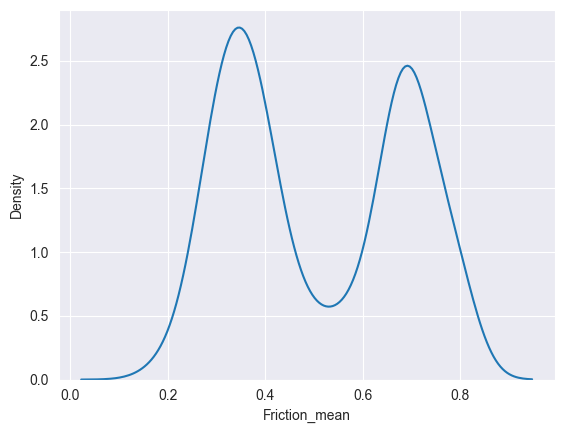

In [67]:
sns.kdeplot(x = sample['Friction_mean'])

<AxesSubplot:xlabel='Friction_mean', ylabel='Count'>

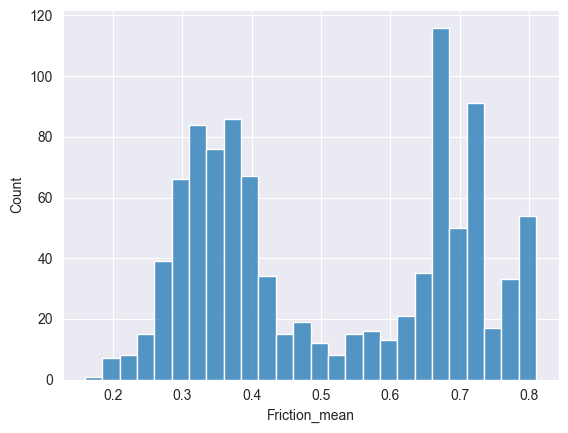

In [68]:
sns.histplot(x = sample['Friction_mean'], binwidth=0.025)

In [69]:
from scipy.stats import norm
from scipy.optimize import minimize

def EM_mixture_sep(data: np.array, init_z: np.array):
    a = 0.5
    a_prev = a+1
    n = data.shape[0]
    z = init_z

    sigma1, sigma2 = 0, 0
    mu1, mu2 = 0, 0
    loglikelihood, loglikelihood_prev = -np.inf, -np.inf
    i=0
    while np.abs(a - a_prev) > 1e-6 or loglikelihood == -np.inf:
        print(i)
        i+=1
        mu1 = ((1-z)*data).sum()/ (n - z.sum())
        mu2 = (z*data).sum()/ (z.sum())

        sigma1 = ((1-z)*(data - mu1)**2).sum()/(n - z.sum())
        sigma2 = (z*(data - mu2)**2).sum()/(z.sum())
        print(loglikelihood)
        z = a*norm.pdf(data, loc = mu2, scale = np.sqrt(sigma2)) / ((1-a)*norm.pdf(data, loc = mu1, scale = np.sqrt(sigma1)) + a*norm.pdf(data, loc = mu2, scale = np.sqrt(sigma2)))
        a_prev = a
        a = z.sum()/n
        loglikelihood_prev = loglikelihood
        loglikelihood = np.log((1-a)*norm.pdf(data, loc = mu1, scale = np.sqrt(sigma1)) + a*norm.pdf(data, loc = mu2, scale = np.sqrt(sigma2))).sum()
    return {'mu1': mu1, 'mu2': mu2, 'sigma1': sigma1, 'sigma2': sigma2, 'alpha': a, 'loglikelihood': loglikelihood}




In [70]:
res = EM_mixture_sep(sample['Friction_mean'].values, (sample['Friction_mean'].values > 0.5).astype(int))
res

0
-inf
1
648.099975019057
2
649.153477787171
3
649.6325693816491
4
649.7971496618077
5
649.8541483249176
6
649.8740852453902
7
649.8811100379148
8
649.8835971531706
9
649.884480367179
10
649.8847945900134
11
649.8849065068914
12
649.8849463952585
13
649.884960617653
14
649.8849656899479
15
649.8849674992008
16
649.884968144605


{'mu1': 0.3525776059089407,
 'mu2': 0.6944188493648833,
 'sigma1': 0.004259220238739424,
 'sigma2': 0.004062288003619298,
 'alpha': 0.46308563475092923,
 'loglikelihood': 649.8849683748481}

In [71]:
np.sqrt(res['sigma1']), np.sqrt(res['sigma2'])

(0.06526270174256828, 0.06373608086177952)

In [73]:
x_grid = np.linspace(start=sample['Friction_mean'].min(), stop=sample['Friction_mean'].max())

In [74]:
pdf1 = lambda x: norm.pdf(x, loc = res['mu1'], scale = np.sqrt(res['sigma1']))
pdf2 = lambda x: norm.pdf(x, loc = res['mu2'], scale = np.sqrt(res['sigma2']))

cdf1 = lambda x: norm.cdf(x, loc = res['mu1'], scale = np.sqrt(res['sigma1']))
cdf2 = lambda x: norm.cdf(x, loc = res['mu2'], scale = np.sqrt(res['sigma2']))

pdf_unb = lambda x: res['alpha']*pdf1(x) + (1-res['alpha'])*pdf2(x)
cdf_unb = lambda x: res['alpha']*cdf1(x) + (1-res['alpha'])*cdf2(x)

restr_const = cdf_unb(sample['Friction_mean'].max()) - cdf_unb(sample['Friction_mean'].min())

pdf = lambda x: pdf_unb(x)/restr_const
cdf = lambda x: cdf_unb(x)/restr_const

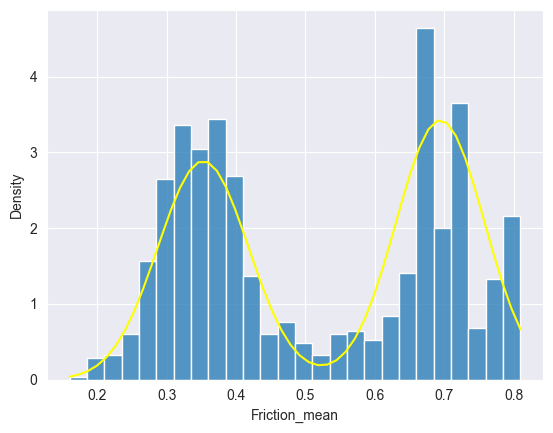

In [75]:
sns.histplot(x = sample['Friction_mean'], binwidth=0.025, stat='density')
#plt.plot(x_grid, pdf1(x_grid), c = 'green')
#plt.plot(x_grid, pdf2(x_grid), c = 'red')
plt.plot(x_grid, pdf(x_grid), c = "yellow")

Моделируем смесь с использованием метода Box-Muller

In [76]:
def boxmuller(n):
    size = n
    if n % 2 != 0:
        size+=1
    res = np.zeros(shape=(2, size//2))
    alpha = np.random.uniform(size=size).reshape((2, size//2))
    mul = np.sqrt(-2*np.log(alpha[0,:]))
    res[0,:], res[1,:] = mul*np.sin(2*np.pi*alpha[1,:]), mul*np.cos(2*np.pi*alpha[1,:])
    return res.reshape(size)[:n]

<AxesSubplot:ylabel='Count'>

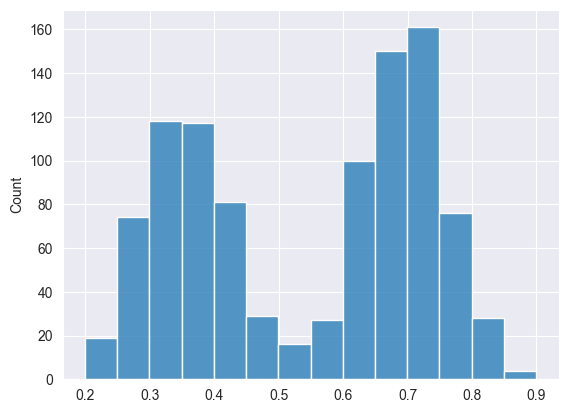

In [77]:
np.random.seed(42)
eta = boxmuller(1000)
alpha = np.random.uniform(size=1000)
eta[alpha > res['alpha']] = eta[alpha > res['alpha']]*np.sqrt(res['sigma2']) + res['mu2']
eta[alpha < res['alpha']] = eta[alpha < res['alpha']]*np.sqrt(res['sigma1']) + res['mu1']
sns.histplot(x = eta, binwidth=0.05)

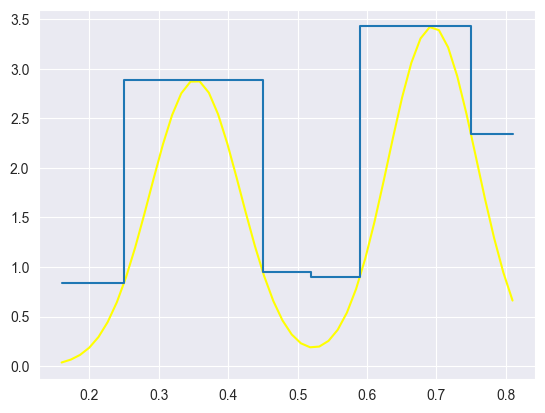

In [161]:
leftmax, rightmax = pdf(res['mu1']), pdf(res['mu2'])
partition = np.array([x_grid.min(), 0.25, 0.45, 0.52, 0.59, 0.75, x_grid.max()])
hats = np.array([pdf(0.25), leftmax, pdf(0.45), pdf(0.59), rightmax, pdf(0.75)])
plt.plot(x_grid, pdf(x_grid), c = "yellow")
plt.plot(partition.repeat(2)[1:13],
         hats.repeat(2))

In [162]:
intervals = [(partition[i], partition[i+1]) for i in range(6)]
ilen = partition[6] - partition[0]
probs = np.array([(partition[i+1]-partition[i])/ilen for i in range(6)])
probs

array([0.13846154, 0.30769231, 0.10769231, 0.10769231, 0.24615385,
       0.09230769])

In [163]:
intervals

[(0.16, 0.25),
 (0.25, 0.45),
 (0.45, 0.52),
 (0.52, 0.59),
 (0.59, 0.75),
 (0.75, 0.81)]

Реализация accept-rejection sampling с разбивкой: если в векторе компоненты не проходит условие с производной Радона-Никодима, то на следующем испытании мы перебрасываем только эти компоненты. Здесь мажоранта получается как "крышка" над нужным интервалом, так как сэмплируем из равномерного распределения

Для моделирования распределения $\mathcal{P}$ с плотностью $f(x)$ сэмплированием из распределения $\mathcal{Q}$ с плотностью $q(x)$, нужно, чтобы первое было абсолютно непрерывным относительно второго, то есть
$$ \forall x:\ g(x) = 0 \implies f(x)=0 $$
при этом нужно, чтобы $\exists M > 0: \frac{f(x)}{g(x)} \le M$.
На каждой итерации ARS проверяется условие с $\alpha \sim Uniform(0,1)$ и $\eta \sim \mathcal{Q}$:
$$ M\alpha < \frac{f(\eta)}{g(\eta)} $$

Для функции ниже важно, чтобы sampling_function уже знала параметры распределения

In [176]:
def ARS(targetdensity, samplingdendity, sampling_function, M, n):
    ans = np.zeros(n)
    reject = np.linspace(start=0, stop=n-1, num=n, dtype=np.int32)
    nleft = n
    while nleft > 0:
        print(nleft)
        ans[reject] = sampling_function(size=nleft)
        alpha = np.random.uniform(size=nleft)

        reject = reject[M*samplingdendity(ans[reject])*alpha >= targetdensity(ans[reject])]
        nleft = reject.shape[0]
    return ans

1000
237
57
24
7


<AxesSubplot:ylabel='Count'>

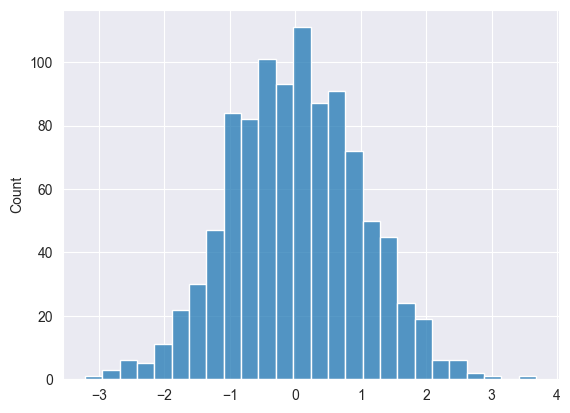

In [177]:
from scipy.stats import laplace
sns.histplot(x=ARS(norm.pdf, laplace.pdf, np.random.laplace, M = np.sqrt(2/np.pi)*np.exp(0.5), n=1000))

In [164]:
def ARS_uniform(density, probs, partition, hats, n):
    ans = np.zeros(n)
    reject = np.linspace(start=0, stop=n-1, num=n, dtype=np.int32)
    nleft = n
    nbins = len(probs)
    reject_in = [0]*nbins
    numbers = list(range(nbins))
    while nleft > 0:
        k = np.random.choice(a=numbers, replace=True, p=probs, size=nleft)
        alpha = np.random.uniform(size=nleft)
        for i in range(nbins):
            if np.any(k==i):
                ans[reject[k==i]] = np.random.uniform(low=partition[i][0], high=partition[i][1], size=(k==i).sum())
                reject_filter = alpha[k==i] >= (density(ans[reject[k==i]])/hats[i])
                reject_in[i] = reject[k==i][reject_filter]
        reject = np.concatenate(reject_in, axis=None)
        nleft = reject.shape[0]
    return ans

ARS с разбивкой по интервалам: вероятность выбрать интервал пропорциональна его длине

<AxesSubplot:ylabel='Count'>

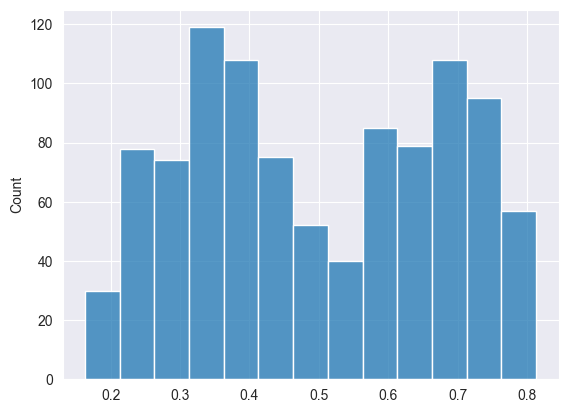

In [180]:
np.random.seed(42)
arsres = ARS_uniform(pdf, probs=probs, partition=intervals, hats=hats, n=1000)

sns.histplot(x=arsres, binwidth=0.05)

In [179]:
from scipy.stats import kstest
kstest(arsres, cdf)

KstestResult(statistic=0.10750144574901327, pvalue=4.301667140398335e-101)

In [154]:
np.sort(eta)

array([0.19941503, 0.2023076 , 0.21502764, 0.22295561, 0.22937855,
       0.2335469 , 0.23366514, 0.23383514, 0.23385468, 0.23786723,
       0.2405143 , 0.24292534, 0.24523418, 0.24549533, 0.24772878,
       0.24842801, 0.24864014, 0.24867209, 0.24930825, 0.25181053,
       0.25194555, 0.25231973, 0.25252492, 0.25660533, 0.25772002,
       0.25979497, 0.26047271, 0.26058112, 0.26261317, 0.26472294,
       0.26567102, 0.26592281, 0.26628193, 0.26690646, 0.26697746,
       0.2670641 , 0.26833822, 0.26922499, 0.26941409, 0.26992599,
       0.27103714, 0.27141946, 0.2719299 , 0.27200257, 0.27221337,
       0.27466341, 0.27571965, 0.277813  , 0.27805591, 0.27888656,
       0.27926658, 0.27937417, 0.27955032, 0.27986999, 0.28006072,
       0.28051817, 0.28122504, 0.28144076, 0.28224358, 0.28419581,
       0.28426186, 0.28463707, 0.28503453, 0.2852709 , 0.28555768,
       0.28611769, 0.28682853, 0.287994  , 0.28807468, 0.28835425,
       0.28850979, 0.28907008, 0.28920975, 0.2916341 , 0.29178

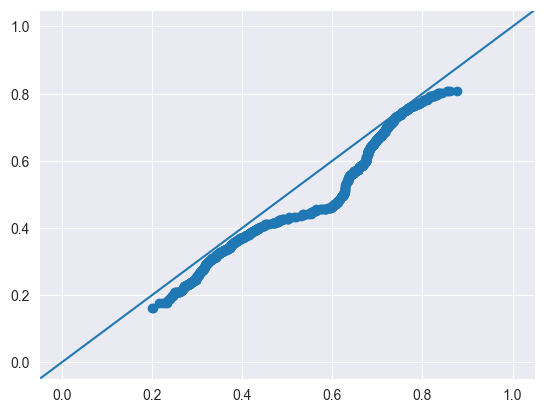

In [155]:
plt.scatter(x = np.sort(eta), y=np.sort(arsres))
plt.axline((0,0),(1,1))

In [22]:
def continuous_bisect_fun_left(f, v, lo, hi):
    val_range = [lo, hi]
    k = 0.5 * sum(val_range)
    for i in range(32):
        val_range[int(f(k) > v)] = k
        next_k = 0.5 * sum(val_range)
        if next_k == k:
            break
        k = next_k
    return k

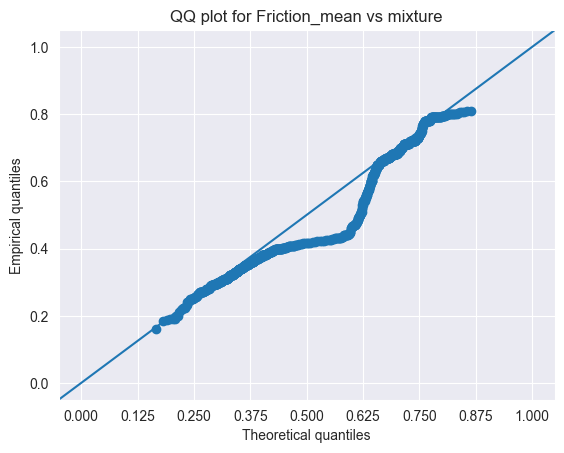

In [23]:
from scipy.stats import norm
f = lambda x: res['alpha']*norm.cdf(x, loc=res['mu1'], scale=np.sqrt(res['sigma1'])) + \
              (1-res['alpha'])*norm.cdf(x, loc=res['mu2'], scale=np.sqrt(res['sigma2']))
N = 1000
quants = [continuous_bisect_fun_left(f, i/(N+2), 0, 1) for i in range(1,N+1)]

plt.scatter(y=sample['Friction_mean'].sort_values(), x=quants)
plt.axline((0,0),(1,1))
plt.xlabel("Theoretical quantiles")
plt.ylabel("Empirical quantiles")
plt.title("QQ plot for Friction_mean vs mixture")
plt.xticks(ticks=np.linspace(0, 1, 9))
plt.grid(True)


In [24]:
from scipy.stats import kstest
kstest(eta, sample['Friction_mean'])

KstestResult(statistic=0.105, pvalue=3.209982841805882e-05)

Сэмплируем из смеси гауссовсских распределений

<AxesSubplot:ylabel='Count'>

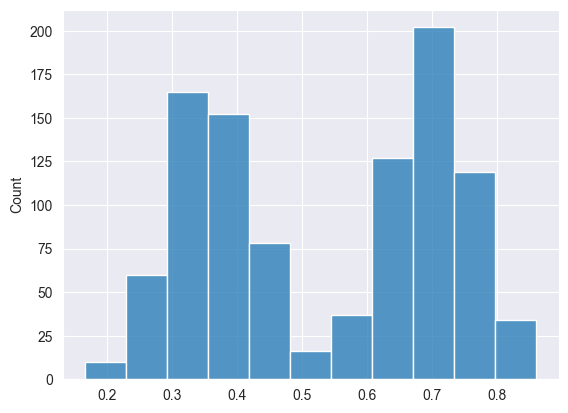

In [25]:
np.random.seed(42)
trial = np.random.uniform(size=1000) < res['alpha']
synsample = np.random.normal(size=1000)
synsample[trial] = synsample[trial]*np.sqrt(res['sigma1'])+res['mu1']
synsample[~trial] = synsample[~trial]*np.sqrt(res['sigma2'])+res['mu2']
sns.histplot(x=synsample)

In [26]:
kstest(synsample, sample['Friction_mean'])

KstestResult(statistic=0.086, pvalue=0.0012207544622917959)

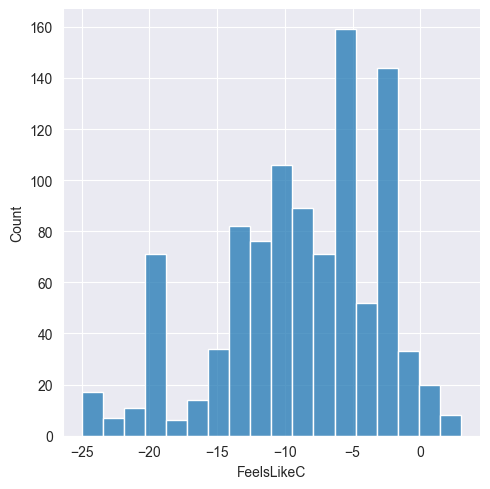

In [27]:
sns.displot(data=sample, x='FeelsLikeC')

In [28]:
mean, std = sample['FeelsLikeC'].mean(), sample['FeelsLikeC'].std()
mean, std

(-8.867, 5.873824377082857)

In [29]:
np.random.seed(42)
synsample1 = np.random.normal(size=1000)*std + mean

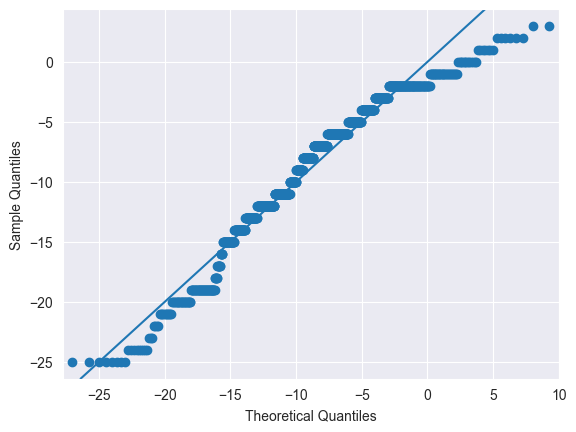

In [30]:
qqplot(sample['FeelsLikeC'], loc=mean, scale=std)
plt.axline((0,0),(1,1))

<AxesSubplot:ylabel='Count'>

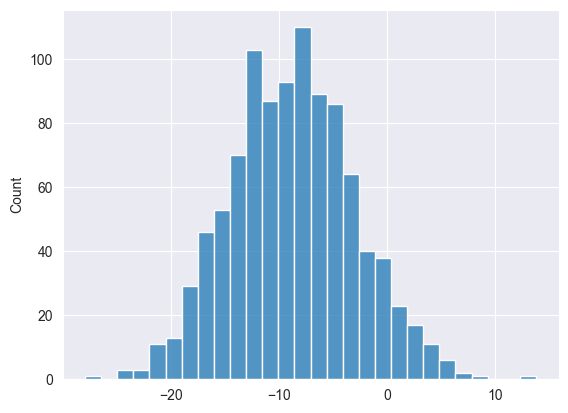

In [31]:
sns.histplot(synsample1)

In [41]:
kstest(sample['windspeedKmph'], cdf=lambda x: norm.cdf(x, loc=mean, scale=std))

KstestResult(statistic=0.9763248542810157, pvalue=0.0)

In [32]:
kstest(synsample1, sample['FeelsLikeC'])

KstestResult(statistic=0.114, pvalue=4.441088228134397e-06)

<AxesSubplot:xlabel='windspeedKmph', ylabel='Count'>

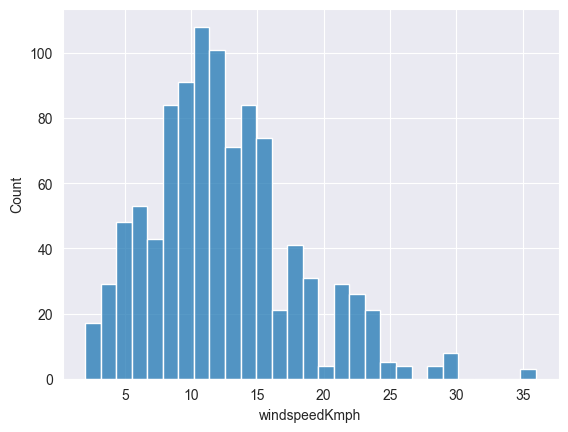

In [33]:
sns.histplot(sample['windspeedKmph'])

Моделируем распределение Коши методом обратных функций

(0.0, 35.0)

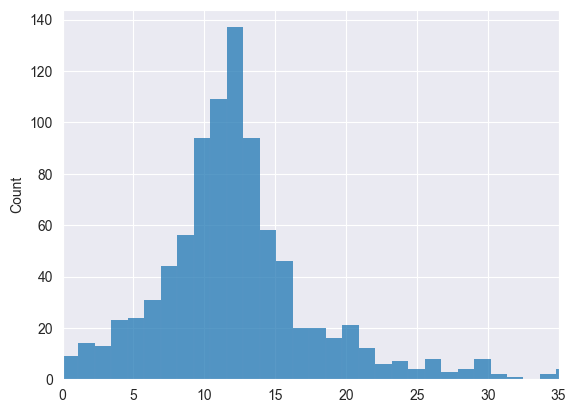

In [34]:
np.random.seed(42)
trials = np.random.uniform(size=1000)
loc, scale = 11.637208293855371, 2.8297116375524167
synsample2 = np.tan(np.pi*(trials-0.5))*scale+loc
sns.histplot(synsample2)
plt.xlim((0, 35))

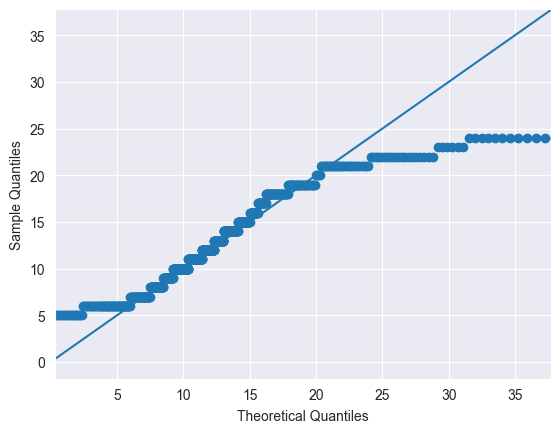

In [35]:
from scipy.stats import cauchy

qqplot(sample['windspeedKmph'], dist=cauchy, loc=loc, scale=scale)
plt.xlim(plt.ylim())
plt.axline((0,0),(1,1))

In [40]:
kstest(sample['windspeedKmph'], cdf=lambda x: cauchy.cdf(x, loc=loc, scale=scale))

KstestResult(statistic=0.09877648630361119, pvalue=6.041225215195301e-09)

In [36]:
kstest(synsample2, sample['windspeedKmph'])

KstestResult(statistic=0.106, pvalue=2.597590093504764e-05)

(0.0, 35.0)

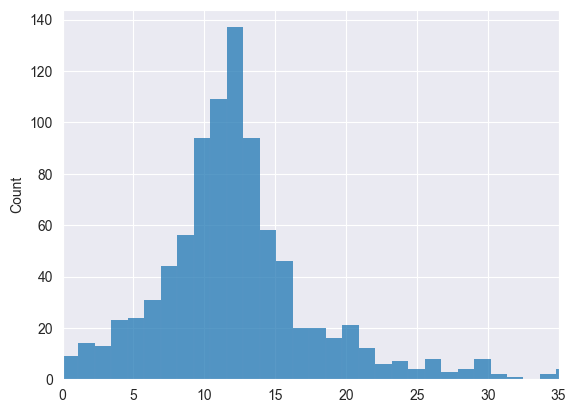

In [37]:
np.random.seed(42)
synsample21 = np.tan(2*np.pi*np.random.uniform(size=1000))*scale+loc
sns.histplot(synsample2)
plt.xlim((0, 35))

<AxesSubplot:xlabel='Water_mean', ylabel='Count'>

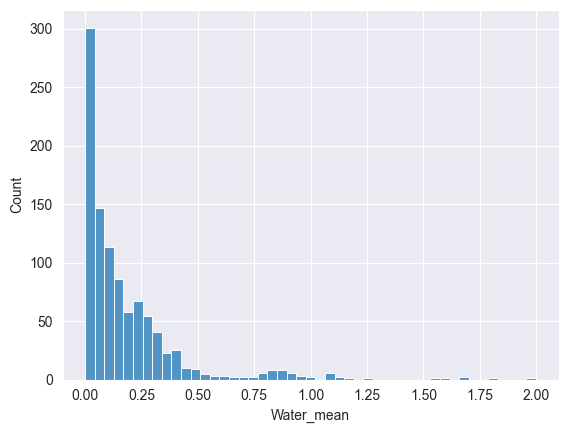

In [43]:
sns.histplot(x=sample['Water_mean'])

In [38]:
kstest(synsample21, sample['windspeedKmph'])

KstestResult(statistic=0.092, pvalue=0.000418604197209586)

In [33]:
#sample = pd.read_csv("../Lab1/sample.csv")

In [34]:
sample.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'lat_', 'lon_', 'State_', 'Ta_mean',
       'Ta_min', 'Ta_max', 'Tsurf_mean', 'Tsurf_min', 'Tsurf_max',
       'Water_mean', 'Water_min', 'Water_max', 'Speed_mean', 'Speed_min',
       'Speed_max', 'Height_mean', 'Height_min', 'Height_max', 'Tdew_mean',
       'Tdew_min', 'Tdew_max', 'Friction_mean', 'Friction_min', 'Friction_max',
       'Date', 'Time', 'Direction_min', 'Direction_max', 'FullDate',
       'ClosestCity', 'date_time', 'maxtempC', 'mintempC', 'totalSnow_cm',
       'sunHour', 'uvIndex', 'moon_illumination', 'moonrise', 'moonset',
       'sunrise', 'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph',
       'location'],
      dtype='object')

In [35]:
predictors = ['humidity', 'State_', 'pressure', 'Height_mean', 'totalSnow_cm', 'Water_mean', 'moon_illumination']
target = ['windspeedKmph', 'FeelsLikeC', 'Friction_mean']
allfeatures = target + predictors

<AxesSubplot:>

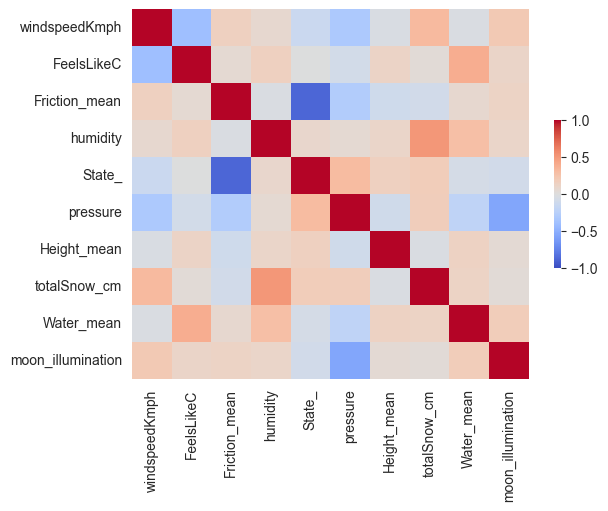

In [36]:
sns.heatmap(data=sample[allfeatures].corr(),
            cmap = "coolwarm",
            cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
            vmin=-1, vmax=1, center=0, annot_kws={"fontsize":8})

In [37]:
from Lab1.corr_significance import multiple_corr_test

In [38]:
corr1 = multiple_corr_test(sample, pivot='windspeedKmph', regressors=predictors)
corr1[corr1['p-value']<0.05]

,$\rho$,left,right,p-value
humidity,0.076246,0.014321,0.137589,1.588231e-02
State_,-0.138142,-0.198436,-0.076807,1.165098e-05
pressure,-0.315770,-0.370511,-0.258844,1.366632e-24
totalSnow_cm,0.314295,0.257316,0.369097,2.297680e-24
moon_illumination,0.217900,0.158042,0.276163,3.264125e-12


In [39]:
corr2 = multiple_corr_test(sample, pivot='Friction_mean', regressors=predictors)
corr2[corr2['p-value']<0.05]

,$\rho$,left,right,p-value
State_,-0.878724,-0.892119,-0.863785,7.905050e-323
pressure,-0.281915,-0.338001,-0.223834,1.001731e-19
Height_mean,-0.102377,-0.163333,-0.040642,1.187311e-03
totalSnow_cm,-0.087782,-0.148965,-0.025930,5.472678e-03
Water_mean,0.071716,0.009767,0.133118,2.333191e-02
moon_illumination,0.125759,0.064267,0.186300,6.671204e-05


In [40]:
corr3 = multiple_corr_test(sample, pivot='FeelsLikeC', regressors=predictors)
corr3[corr3['p-value']<0.05]

,$\rho$,left,right,p-value
humidity,0.153972,0.092865,0.213923,9.974678e-07
pressure,-0.079740,-0.141036,-0.017835,1.165389e-02
Height_mean,0.122230,0.060697,0.182837,1.066483e-04
Water_mean,0.397541,0.344027,0.448481,3.321284e-39
moon_illumination,0.110915,0.049260,0.171727,4.415945e-04


In [41]:
spredictors = ['moon_illumination', 'Water_mean', 'Height_mean', 'pressure', 'State_', 'totalSnow_cm', 'humidity']

In [42]:
from bamt.Networks import HybridBN
from bamt import Preprocessors

In [43]:
from sklearn import preprocessing

In [44]:
sample1 = sample[target+spredictors]

In [45]:
encoder = preprocessing.LabelEncoder()
discretizer = preprocessing.KBinsDiscretizer(n_bins=4, encode="ordinal", strategy="quantile")
p = Preprocessors.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
disc_sample, est = p.apply(sample1)

In [46]:
data_disc = sample1

In [47]:
disc_sample

,windspeedKmph,FeelsLikeC,Friction_mean,moon_illumination,Water_mean,Height_mean,pressure,State_,totalSnow_cm,humidity
0,9,-4,0,62,2,3,1030,5,1,79
1,21,-10,3,83,3,3,1002,3,1,89
2,26,-12,1,2,0,0,1020,6,1,94
3,13,-13,3,9,0,1,1013,1,0,76
4,18,-11,1,90,3,3,1004,4,0,78
...,...,...,...,...,...,...,...,...,...,...
995,6,-5,1,52,1,3,1018,6,0,72
996,10,-13,3,23,1,1,1014,2,0,78
997,5,1,2,50,3,3,998,3,0,74
998,15,-20,1,93,0,2,1008,5,0,75


In [48]:
p.info

{'types': {'windspeedKmph': 'disc_num',
  'FeelsLikeC': 'disc_num',
  'Friction_mean': 'cont',
  'moon_illumination': 'disc_num',
  'Water_mean': 'cont',
  'Height_mean': 'cont',
  'pressure': 'disc_num',
  'State_': 'disc_num',
  'totalSnow_cm': 'cont',
  'humidity': 'disc_num'},
 'signs': {'Friction_mean': 'pos',
  'Water_mean': 'pos',
  'Height_mean': 'pos',
  'totalSnow_cm': 'pos'}}

In [49]:
col_to_fix=['windspeedKmph', 'humidity', 'pressure', 'FeelsLikeC', 'moon_illumination']
disc_sample1 = pd.DataFrame(columns=col_to_fix)
for feat in sample1.columns.difference((disc_sample1.columns + ['State_'])):
    disc_sample1[feat] = disc_sample[feat]
disc_sample1['State_'] = sample1['State_']-1
for feat in col_to_fix:
    disc_sample1[feat] = pd.qcut(sample1[feat], q = [0, 0.25, 0.5, 0.75, 1], duplicates='drop')

disc_sample1

,windspeedKmph,humidity,pressure,FeelsLikeC,moon_illumination,Friction_mean,Height_mean,State_,Water_mean,totalSnow_cm
0,"(1.999, 9.0]","(77.0, 86.0]","(1017.0, 1030.0]","(-8.0, -4.0]","(46.0, 79.0]",0,3,4,2,1
1,"(15.0, 36.0]","(86.0, 100.0]","(990.999, 1005.0]","(-12.0, -8.0]","(79.0, 100.0]",3,3,2,3,1
2,"(15.0, 36.0]","(86.0, 100.0]","(1017.0, 1030.0]","(-25.001, -12.0]","(0.999, 25.0]",1,0,5,0,1
3,"(12.0, 15.0]","(71.0, 77.0]","(1010.5, 1017.0]","(-25.001, -12.0]","(0.999, 25.0]",3,1,0,0,0
4,"(15.0, 36.0]","(77.0, 86.0]","(990.999, 1005.0]","(-12.0, -8.0]","(79.0, 100.0]",1,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...
995,"(1.999, 9.0]","(71.0, 77.0]","(1017.0, 1030.0]","(-8.0, -4.0]","(46.0, 79.0]",1,3,5,1,0
996,"(9.0, 12.0]","(77.0, 86.0]","(1010.5, 1017.0]","(-25.001, -12.0]","(0.999, 25.0]",3,1,1,1,0
997,"(1.999, 9.0]","(71.0, 77.0]","(990.999, 1005.0]","(-4.0, 3.0]","(46.0, 79.0]",2,3,2,3,0
998,"(12.0, 15.0]","(71.0, 77.0]","(1005.0, 1010.5]","(-25.001, -12.0]","(79.0, 100.0]",1,2,4,0,0


In [50]:
for feat in col_to_fix:
    d = dict(enumerate(disc_sample1[feat].cat.categories))
    invd = {value: key for key, value in d.items()}
    disc_sample1[feat] = disc_sample1[feat].map(invd)
    disc_sample1[feat] = disc_sample1[feat].astype(np.int32)

In [51]:
disc_sample1

,windspeedKmph,humidity,pressure,FeelsLikeC,moon_illumination,Friction_mean,Height_mean,State_,Water_mean,totalSnow_cm
0,0,2,3,2,2,0,3,4,2,1
1,3,3,0,1,3,3,3,2,3,1
2,3,3,3,0,0,1,0,5,0,1
3,2,1,2,0,0,3,1,0,0,0
4,3,2,0,1,3,1,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...
995,0,1,3,2,2,1,3,5,1,0
996,1,2,2,0,0,3,1,1,1,0
997,0,1,0,3,2,2,3,2,3,0
998,2,1,1,0,3,1,2,4,0,0


In [52]:
disc_sample1.dtypes

windspeedKmph        int32
humidity             int32
pressure             int32
FeelsLikeC           int32
moon_illumination    int32
Friction_mean        int32
Height_mean          int32
State_               int64
Water_mean           int32
totalSnow_cm         int32
dtype: object

In [53]:
p.info

{'types': {'windspeedKmph': 'disc_num',
  'FeelsLikeC': 'disc_num',
  'Friction_mean': 'cont',
  'moon_illumination': 'disc_num',
  'Water_mean': 'cont',
  'Height_mean': 'cont',
  'pressure': 'disc_num',
  'State_': 'disc_num',
  'totalSnow_cm': 'cont',
  'humidity': 'disc_num'},
 'signs': {'Friction_mean': 'pos',
  'Water_mean': 'pos',
  'Height_mean': 'pos',
  'totalSnow_cm': 'pos'}}

In [54]:
sample1['humidity'].value_counts()

77     79
76     57
72     56
81     44
78     44
79     40
75     39
69     37
95     37
94     33
74     31
68     30
91     29
73     29
89     27
99     25
67     24
80     23
70     23
71     20
83     20
90     18
93     17
59     15
66     15
87     14
62     13
88     13
46     13
82     13
58     10
92     10
85      9
98      9
86      8
63      8
96      7
84      7
65      7
100     6
60      6
61      6
55      6
47      5
53      4
49      4
51      2
54      2
39      2
57      1
35      1
64      1
42      1
Name: humidity, dtype: int64

In [55]:
sample1['pressure'].value_counts()

1013    78
1008    71
1007    65
1016    55
999     46
1006    43
1020    40
1003    40
1002    39
1015    36
1010    35
1024    35
1005    33
1014    29
1018    29
1012    29
1004    27
1009    26
1027    25
1017    19
1025    18
1000    17
1001    17
1011    16
1019    16
1022    16
998     15
1023    14
1030    13
1029    13
1026    10
991      7
993      7
995      6
1028     5
1021     4
997      4
996      2
Name: pressure, dtype: int64

In [56]:
sample1['windspeedKmph'].value_counts()

11    108
12    101
10     91
14     84
13     71
6      53
15     49
5      48
7      43
8      42
9      42
18     41
19     31
21     29
4      29
16     25
17     21
24     21
22     20
3      15
29      8
23      6
25      5
20      4
26      4
28      4
36      3
2       2
Name: windspeedKmph, dtype: int64

In [57]:
sample1['moon_illumination'].value_counts()

50     56
100    47
93     47
42     47
5      47
9      46
38     35
79     35
25     35
32     33
72     29
12     29
43     28
97     27
90     27
46     27
83     27
76     24
86     22
2      22
70     21
16     20
36     20
56     19
1      19
49     18
23     16
15     15
52     14
69     13
45     12
87     11
53     10
8      10
39     10
29      9
96      9
73      9
33      8
18      8
80      8
62      7
35      7
60      6
22      6
66      4
59      1
Name: moon_illumination, dtype: int64

In [58]:
sample1['FeelsLikeC'].value_counts()

-6     101
-2      96
-12     76
-11     74
-7      71
-5      58
-8      55
-4      52
-3      48
-19     47
-13     45
-14     37
-15     34
-9      34
-1      33
-10     32
-20     24
 0      13
-21     11
-24      9
-17      8
-25      8
 1       7
 2       6
-18      6
-16      6
-22      4
-23      3
 3       2
Name: FeelsLikeC, dtype: int64

In [59]:
for feat in sample1[['moon_illumination', 'windspeedKmph', 'pressure']]:
    p.info['types'][feat] = 'cont'
    p.info['signs'][feat] = 'pos'

In [60]:
from bamt.Networks import HybridBN

In [61]:
bn = HybridBN(use_mixture=True, has_logit=False)

In [62]:
bn.add_nodes(p.info)

In [63]:
bn.nodes_names

['windspeedKmph',
 'FeelsLikeC',
 'Friction_mean',
 'moon_illumination',
 'Water_mean',
 'Height_mean',
 'pressure',
 'State_',
 'totalSnow_cm',
 'humidity']

In [64]:
bn.add_edges(data = disc_sample1, scoring_function=("BIC",))

In [65]:
bn.edges

[['FeelsLikeC', 'windspeedKmph'],
 ['pressure', 'windspeedKmph'],
 ['State_', 'windspeedKmph'],
 ['humidity', 'FeelsLikeC'],
 ['pressure', 'Friction_mean'],
 ['State_', 'Friction_mean'],
 ['windspeedKmph', 'Friction_mean'],
 ['pressure', 'moon_illumination'],
 ['State_', 'moon_illumination'],
 ['windspeedKmph', 'moon_illumination'],
 ['pressure', 'Water_mean'],
 ['State_', 'Water_mean'],
 ['windspeedKmph', 'Water_mean'],
 ['pressure', 'Height_mean'],
 ['State_', 'Height_mean'],
 ['windspeedKmph', 'Height_mean'],
 ['humidity', 'pressure'],
 ['FeelsLikeC', 'pressure'],
 ['State_', 'pressure'],
 ['humidity', 'State_'],
 ['FeelsLikeC', 'State_'],
 ['pressure', 'totalSnow_cm'],
 ['State_', 'totalSnow_cm'],
 ['windspeedKmph', 'totalSnow_cm']]

![](bn.png)

In [66]:
bn.plot(output='bn.html')

In [67]:
bn.fit_parameters(data=sample1)

In [68]:
bn.distributions

{'humidity': {'cprob': [0.006,
   0.001,
   0.002,
   0.001,
   0.013,
   0.005,
   0.004,
   0.002,
   0.004,
   0.002,
   0.006,
   0.001,
   0.01,
   0.015,
   0.006,
   0.006,
   0.013,
   0.008,
   0.001,
   0.007,
   0.015,
   0.024,
   0.03,
   0.037,
   0.023,
   0.02,
   0.056,
   0.029,
   0.031,
   0.039,
   0.057,
   0.079,
   0.044,
   0.04,
   0.023,
   0.044,
   0.013,
   0.02,
   0.007,
   0.009,
   0.008,
   0.014,
   0.013,
   0.027,
   0.018,
   0.029,
   0.01,
   0.017,
   0.033,
   0.037,
   0.007,
   0.009,
   0.025],
  'vals': ['100',
   '35',
   '39',
   '42',
   '46',
   '47',
   '49',
   '51',
   '53',
   '54',
   '55',
   '57',
   '58',
   '59',
   '60',
   '61',
   '62',
   '63',
   '64',
   '65',
   '66',
   '67',
   '68',
   '69',
   '70',
   '71',
   '72',
   '73',
   '74',
   '75',
   '76',
   '77',
   '78',
   '79',
   '80',
   '81',
   '82',
   '83',
   '84',
   '85',
   '86',
   '87',
   '88',
   '89',
   '90',
   '91',
   '92',
   '93',
   '94',
   '

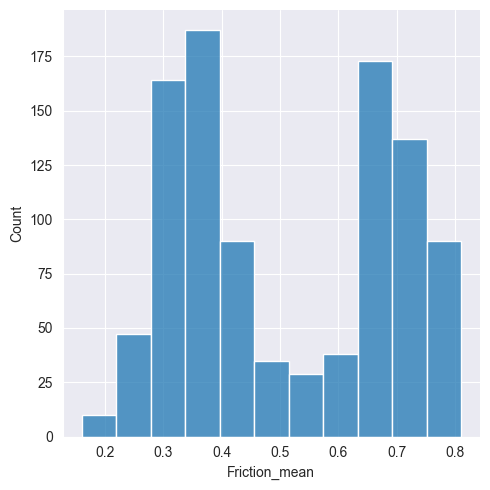

In [69]:
import seaborn as sns
sns.displot(x = sample1['Friction_mean'])

In [70]:
np.random.seed(42)
synthetic = bn.sample(1000, parall_count=2)

100%|██████████| 1000/1000 [00:09<00:00, 101.73it/s]


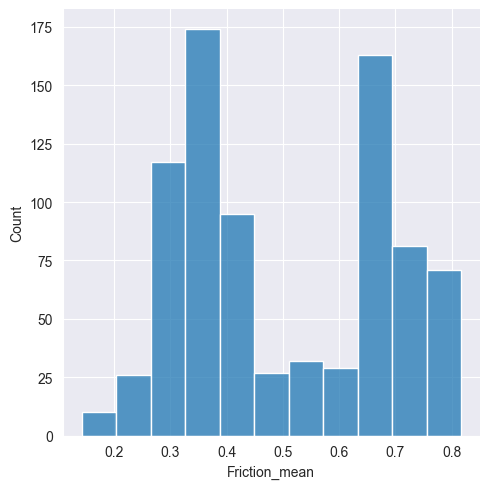

In [71]:
import seaborn as sns
sns.displot(x = synthetic['Friction_mean'])

In [72]:
from scipy.stats import kstest
kstest(sample1['Friction_mean'], synthetic['Friction_mean'])

KstestResult(statistic=0.05348484848484848, pvalue=0.14386194635305452)

Двухвыборочный тест хи-квадрат согласия с распределением
Описание: [ссылка](https://www.itl.nist.gov/div898/software/dataplot/refman1/auxillar/chi2samp.htm)

In [73]:
from scipy.stats import chi2
def chisq_2samp(freq1: np.ndarray, freq2: np.ndarray):
    # it is supposed that the numbers of non-empty bins are equal
    # freq1.shape[0] = freq2.shape[0]
    K1 = np.sqrt(freq2.sum()/freq1.sum())
    K2 = 1/K1
    c = int(freq1.sum()==freq2.sum())
    nbins = freq1.shape[0]
    t = np.sum( (K1*freq1-K2*freq2)**2/(freq1+freq2) )
    return {
    "statistic": t,
    "pvalue": 1 - chi2.cdf(x = t, df = nbins - c)
    }

In [74]:
synthetic.dtypes

humidity              object
FeelsLikeC            object
State_                object
pressure             float64
windspeedKmph        float64
Friction_mean        float64
moon_illumination    float64
Water_mean           float64
Height_mean          float64
totalSnow_cm         float64
dtype: object

In [75]:
for feat in ['humidity', 'FeelsLikeC', 'State_', 'windspeedKmph']:
    synthetic[feat] = synthetic[feat].astype(np.int32)

In [76]:
for feat in ['humidity', 'FeelsLikeC', 'State_']:
    print(feat)
    nbins = min(10, sample1[feat].unique().shape[0])
    freqs1, freqs2 = np.histogram(sample1[feat], bins=nbins)[0], np.histogram(synthetic[feat], bins=nbins)[0]
    print(chisq_2samp(freqs1, freqs2))

humidity
{'statistic': 1.5607194403421798, 'pvalue': 0.9987334803173481}
FeelsLikeC
{'statistic': 3.798097520296544, 'pvalue': 0.9559958124070415}
State_
{'statistic': 12.318978089878362, 'pvalue': 0.05521957254017895}


In [77]:
for feat in sample1.columns.difference(['humidity', 'FeelsLikeC', 'State_']):
    print(feat)
    print(kstest(sample1[feat], synthetic[feat]))

Friction_mean
KstestResult(statistic=0.05348484848484848, pvalue=0.14386194635305452)
Height_mean
KstestResult(statistic=0.04093939393939394, pvalue=0.4205385322042906)
Water_mean
KstestResult(statistic=0.0917878787878788, pvalue=0.0009040063144873349)
moon_illumination
KstestResult(statistic=0.07027272727272728, pvalue=0.02165282114138349)
pressure
KstestResult(statistic=0.06593939393939394, pvalue=0.03707725265593202)
totalSnow_cm
KstestResult(statistic=0.18627272727272728, pvalue=3.430044200355486e-14)
windspeedKmph
KstestResult(statistic=0.07378787878787879, pvalue=0.013650368816294072)


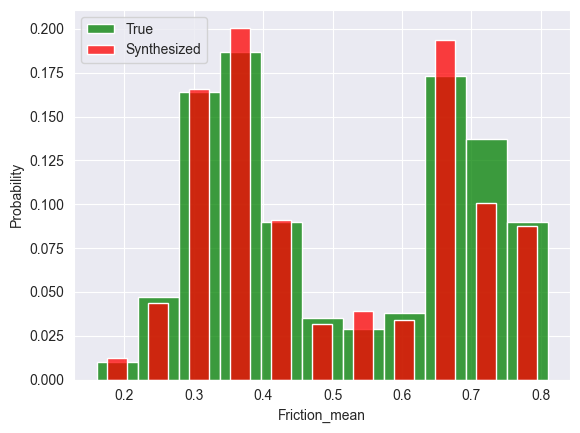

In [78]:
bins = np.histogram_bin_edges(sample1['Friction_mean'], bins='auto')
sns.histplot(x = sample1['Friction_mean'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic['Friction_mean'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

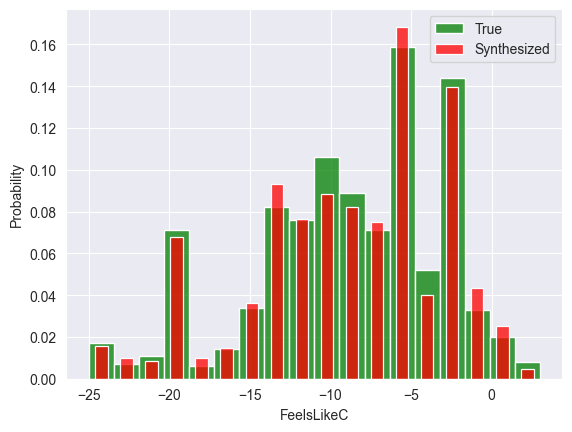

In [79]:
bins = np.histogram_bin_edges(sample1['FeelsLikeC'], bins='auto')
sns.histplot(x = sample1['FeelsLikeC'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic['FeelsLikeC'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

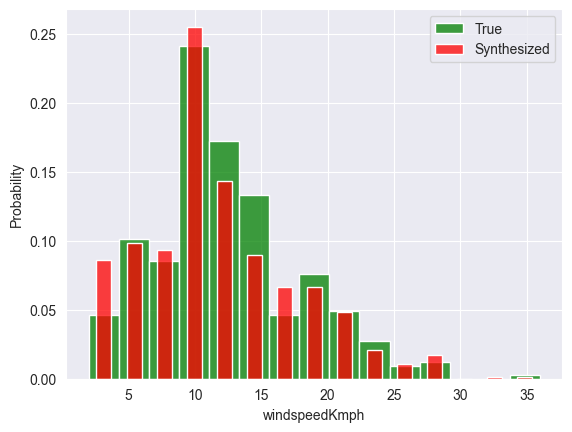

In [80]:
bins = np.histogram_bin_edges(sample1['windspeedKmph'], bins=15)
sns.histplot(x = sample1['windspeedKmph'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic['windspeedKmph'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

In [81]:
bn2 = HybridBN(use_mixture=True)

In [82]:
bn2.add_nodes(p.info)

In [83]:
from pgmpy.estimators import K2Score

In [84]:
bn2.add_edges(data = disc_sample1, scoring_function=("K2",K2Score))

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [85]:
bn2.plot(output='bn2.html')

![](bn2.png)

In [86]:
bn2.fit_parameters(data=sample1)

In [87]:
synthetic2 = bn2.sample(1000, parall_count=1)

100%|██████████| 1000/1000 [00:03<00:00, 267.96it/s]


In [88]:
for feat in ['humidity', 'FeelsLikeC', 'State_', 'windspeedKmph']:
    synthetic2[feat] = synthetic2[feat].astype(np.int32)

In [89]:
for feat in ['humidity', 'FeelsLikeC', 'State_']:
    print(feat)
    nbins = min(10, sample1[feat].unique().shape[0])
    freqs1, freqs2 = np.histogram(sample1[feat], bins=nbins)[0], np.histogram(synthetic2[feat], bins=nbins)[0]
    print(chisq_2samp(freqs1, freqs2))

humidity
{'statistic': 29.228259575475334, 'pvalue': 0.0011442911942627365}
FeelsLikeC
{'statistic': 6.10769883790718, 'pvalue': 0.8061351091793296}
State_
{'statistic': 12.12900704191592, 'pvalue': 0.05915192541192249}


In [90]:
for feat in sample1.columns.difference(['humidity', 'FeelsLikeC', 'State_']):
    print(feat)
    print(kstest(sample1[feat], synthetic2[feat]))

Friction_mean
KstestResult(statistic=0.03611214953271028, pvalue=0.5678200015402816)
Height_mean
KstestResult(statistic=0.02860747663551402, pvalue=0.8305078869579821)
Water_mean
KstestResult(statistic=0.16, pvalue=8.827799468223931e-11)
moon_illumination
KstestResult(statistic=0.03842056074766355, pvalue=0.48815856992811396)
pressure
KstestResult(statistic=0.060738317757009344, pvalue=0.06308075648285008)
totalSnow_cm
KstestResult(statistic=0.0397196261682243, pvalue=0.4457159383866061)
windspeedKmph
KstestResult(statistic=0.08126168224299066, pvalue=0.00419992477253471)


In [91]:
bins

array([ 2.        ,  4.26666667,  6.53333333,  8.8       , 11.06666667,
       13.33333333, 15.6       , 17.86666667, 20.13333333, 22.4       ,
       24.66666667, 26.93333333, 29.2       , 31.46666667, 33.73333333,
       36.        ])

In [92]:
import matplotlib.pyplot as plt

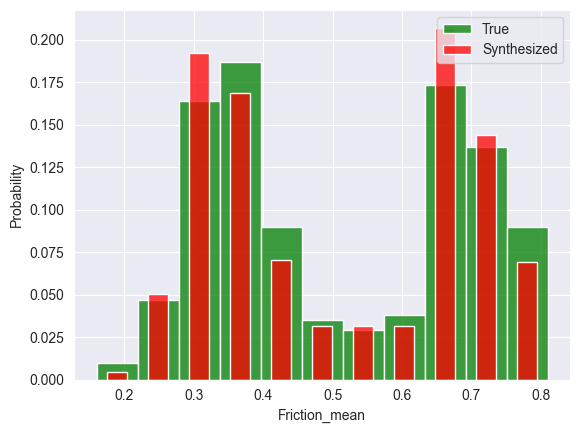

In [93]:
bins = np.histogram_bin_edges(sample1['Friction_mean'], bins='auto')
sns.histplot(x = sample1['Friction_mean'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic2['Friction_mean'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

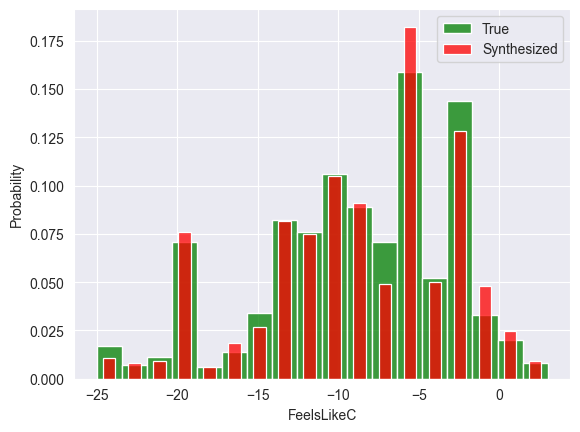

In [94]:
bins = np.histogram_bin_edges(sample1['FeelsLikeC'], bins='auto')
sns.histplot(x = sample1['FeelsLikeC'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic2['FeelsLikeC'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

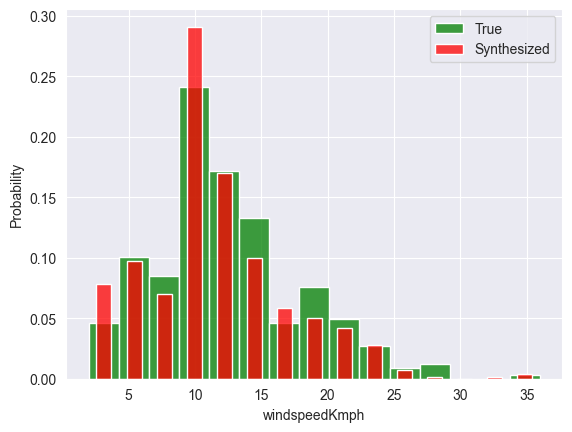

In [95]:
bins = np.histogram_bin_edges(sample1['windspeedKmph'], bins=15)
sns.histplot(x = sample1['windspeedKmph'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic2['windspeedKmph'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

In [96]:
sample1.columns

Index(['windspeedKmph', 'FeelsLikeC', 'Friction_mean', 'moon_illumination',
       'Water_mean', 'Height_mean', 'pressure', 'State_', 'totalSnow_cm',
       'humidity'],
      dtype='object')

In [97]:
bn_man = HybridBN(use_mixture=True, has_logit=False)
bn_man.add_nodes(p.info)
bn_man.edges = [
['windspeedKmph', 'humidity'],
['windspeedKmph', 'State_'],
['pressure', 'windspeedKmph'],
['moon_illumination', 'windspeedKmph'],

['State_', 'Friction_mean'],
['pressure', 'Friction_mean'],
['Height_mean', 'Friction_mean'],
['totalSnow_cm', 'Friction_mean'],
['Water_mean', 'Friction_mean'],
['moon_illumination', 'Friction_mean'],

['humidity', 'FeelsLikeC'],
['pressure', 'FeelsLikeC'],
['Height_mean', 'FeelsLikeC'],
['FeelsLikeC', 'Water_mean'],
['moon_illumination', 'FeelsLikeC'],

['windspeedKmph', 'Friction_mean'],
['windspeedKmph', 'FeelsLikeC']
]

![](bn_man.png)

In [98]:
bn_man.plot(output='bn_man.html')

In [99]:
bn_man.fit_parameters(data=sample1)

In [100]:
synthetic_man = bn_man.sample(1000, parall_count=1)

100%|██████████| 1000/1000 [00:00<00:00, 8928.61it/s]


In [101]:
for feat in ['humidity', 'FeelsLikeC', 'State_', 'windspeedKmph']:
    synthetic_man[feat] = synthetic_man[feat].astype(np.int32)

In [102]:
for feat in ['humidity', 'FeelsLikeC', 'State_']:
    print(feat)
    nbins = min(10, sample1[feat].unique().shape[0])
    freqs1, freqs2 = np.histogram(sample1[feat], bins=nbins)[0], np.histogram(synthetic_man[feat], bins=nbins)[0]
    print(chisq_2samp(freqs1, freqs2))

humidity
{'statistic': 10.719744870173624, 'pvalue': 0.37976525262181215}
FeelsLikeC
{'statistic': 5.309807032521534, 'pvalue': 0.8695453541864517}
State_
{'statistic': 3.2484930353086856, 'pvalue': 0.7770739706019846}


In [103]:
for feat in sample1.columns.difference(['humidity', 'FeelsLikeC', 'State_']):
    print(feat)
    print(kstest(sample1[feat], synthetic_man[feat]))

Friction_mean
KstestResult(statistic=0.18624675324675324, pvalue=4.5796810286330925e-10)
Height_mean
KstestResult(statistic=0.17484848484848484, pvalue=6.410089789682961e-09)
Water_mean
KstestResult(statistic=0.34285281385281385, pvalue=1.72039648894882e-33)
moon_illumination
KstestResult(statistic=0.12629004329004329, pvalue=7.387608743166101e-05)
pressure
KstestResult(statistic=0.12298268398268399, pvalue=0.00012504084558925387)
totalSnow_cm
KstestResult(statistic=0.7141904761904762, pvalue=8.031114735911536e-157)
windspeedKmph
KstestResult(statistic=0.07532034632034632, pvalue=0.05200835103734292)


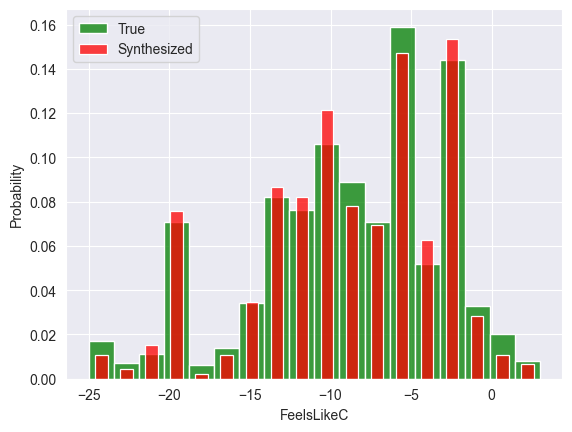

In [104]:
bins = np.histogram_bin_edges(sample1['FeelsLikeC'], bins='auto')
sns.histplot(x = sample1['FeelsLikeC'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic_man['FeelsLikeC'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

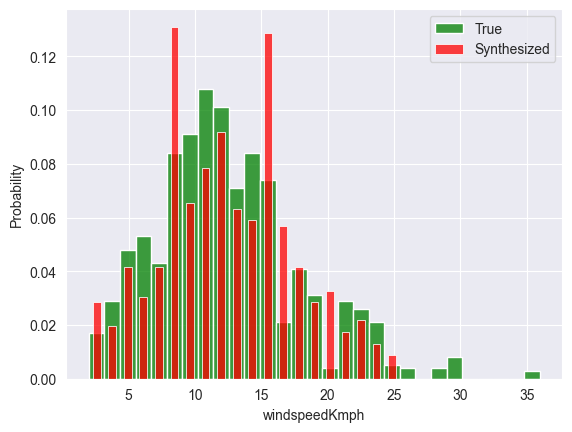

In [105]:
bins = np.histogram_bin_edges(sample1['windspeedKmph'], bins='auto')
sns.histplot(x = sample1['windspeedKmph'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic_man['windspeedKmph'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

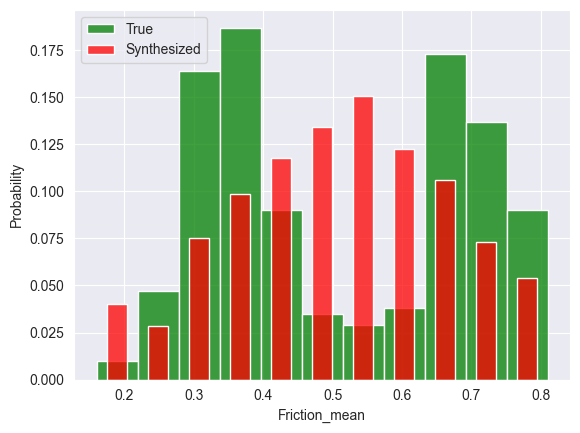

In [106]:
bins = np.histogram_bin_edges(sample1['Friction_mean'], bins='auto')
sns.histplot(x = sample1['Friction_mean'], color='green', stat = 'probability', label='True', bins=bins)
sns.histplot(x = synthetic_man['Friction_mean'], color='red', stat = 'probability', label='Synthesized', bins=bins, shrink=0.5)
plt.legend()

Самые удовлетворительные результаты в рамках задачи о генерации синтетики дала БС bn2, построенная от максимизации K2. Можем посмотреть её в рамках заполнения пропусков.

In [107]:
sample_test = pd.read_csv('../Lab1/test.csv')
sample_test = sample_test[target+spredictors]

In [108]:
sample1_with_missings = sample_test.copy(deep=True)

np.random.seed(42)

misloc = np.random.choice(a=sample1_with_missings.index.values, size=350, replace=False)

for e in misloc:
    row = bn.sample(n=1, evidence={feat: sample_test.loc[e,feat] for feat in spredictors})
    if len(row.columns.values) != 0:
        for feat in target:
            sample1_with_missings.loc[e, feat] = row.loc[0, feat]
    else:
        sample1_with_missings.loc[e, target] = pd.NA

sample1_with_missings.iloc[misloc].head(10)

100%|██████████| 1/1 [00:00<00:00, 125.01it/s]


,windspeedKmph,FeelsLikeC,Friction_mean,moon_illumination,Water_mean,Height_mean,pressure,State_,totalSnow_cm,humidity
521,12.0,-7,0.3584,50,0.060750,38.125,999,4,0.0,71
737,3.0,-8,0.399171,25,0.000000,64.000,1025,6,3.0,93
740,10.0,-6,0.364447,36,0.000000,103.000,1016,6,0.0,46
660,28.590625,-1,0.37253,22,0.000000,73.750,1024,6,6.5,85
411,12.909144,-7,0.397695,16,0.052200,91.400,1018,6,0.0,73
678,12.429256,-11,0.385799,52,0.089600,79.400,1019,6,0.0,71
626,8.0,-14,0.3545,42,0.246000,49.000,1012,6,0.0,55
513,8.0,-11,0.752715,100,0.000000,34.500,1008,1,0.0,78
859,6.0,-14,0.277636,12,0.021000,47.500,1024,5,1.9,87
136,12.0,-6,0.782922,5,0.000667,42.250,1016,1,0.0,74


In [109]:
sample1_with_missings['Friction_mean'].isna().sum()

36

In [110]:
mask = sample1_with_missings['FeelsLikeC'].isna()

In [111]:
sample1_ = sample_test[~mask]
sample1_res = sample1_with_missings[~mask]

In [112]:
for feat in target:
    sample1_res[feat] = sample1_res[feat].astype(np.float32)

In [113]:
sample1_res

,windspeedKmph,FeelsLikeC,Friction_mean,moon_illumination,Water_mean,Height_mean,pressure,State_,totalSnow_cm,humidity
0,7.60000,-14.0,0.306626,9,0.2710,43.000000,1014,5,0.0,76
1,18.00000,-19.0,0.355000,100,0.0000,60.500000,1007,6,0.0,77
2,18.60000,-7.0,0.525531,9,0.1882,39.800000,1010,4,0.0,77
3,30.00000,-11.0,0.363814,9,0.0885,38.000000,1013,4,0.0,77
4,6.00000,-14.0,0.310000,12,0.0245,79.625000,1024,5,1.9,89
...,...,...,...,...,...,...,...,...,...,...
995,10.79818,-13.0,0.290175,5,0.0000,27.000000,1028,6,19.8,86
996,14.00000,-19.0,0.780000,93,0.0120,41.000000,1005,1,0.1,80
997,5.00000,-17.0,0.373333,12,0.0250,37.666667,1024,6,1.9,86
998,9.40000,-14.0,0.385923,42,0.0000,49.000000,1005,5,2.8,81


In [114]:
kstest(sample1_['Friction_mean'], sample1_res['Friction_mean'])

KstestResult(statistic=0.025933609958506226, pvalue=0.9023059424735227)

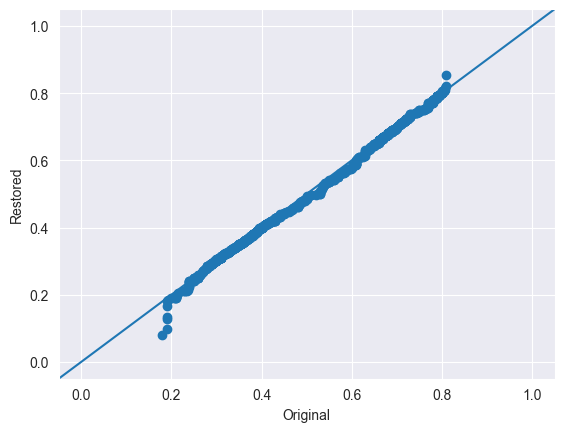

In [115]:
plt.scatter(x=sample1_['Friction_mean'].sort_values(), y=sample1_res['Friction_mean'].sort_values())
plt.axline((0,0),(1,1))
plt.xlabel("Original")
plt.ylabel("Restored")
#plt.xticks(ticks=np.linspace(0, 1, 9))
plt.grid(True)

In [116]:
kstest(sample1_['windspeedKmph'], sample1_res['windspeedKmph'])

KstestResult(statistic=0.046680497925311204, pvalue=0.2443953779935704)

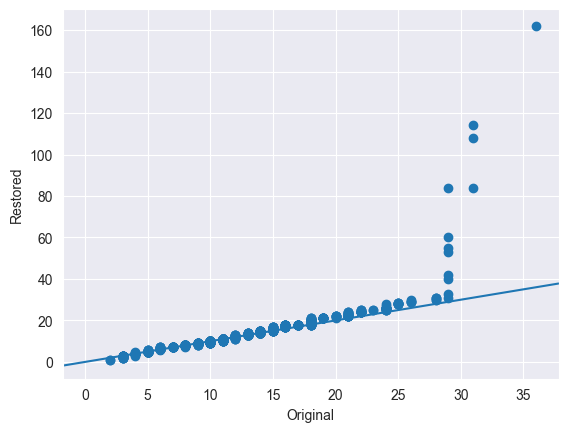

In [117]:
plt.scatter(x=sample1_['windspeedKmph'].sort_values(), y=sample1_res['windspeedKmph'].sort_values())
plt.axline((0,0),(1,1))
plt.xlabel("Original")
plt.ylabel("Restored")
#plt.xticks(ticks=np.linspace(0, 1, 9))
plt.grid(True)

In [118]:
for feat in ['FeelsLikeC']:
    print(feat)
    nbins = min(10, sample1_[feat].unique().shape[0])
    freqs1, freqs2 = np.histogram(sample1_[feat], bins=nbins)[0], np.histogram(sample1_res[feat], bins=nbins)[0]
    print(chisq_2samp(freqs1, freqs2))

FeelsLikeC
{'statistic': 1.8621046668041534, 'pvalue': 0.9934651510642131}


In [119]:
sample1.Friction_mean[misloc]

521    0.375833
737    0.295455
740    0.310000
660    0.680000
411    0.660000
         ...   
420    0.790000
552    0.675000
903    0.630000
90     0.680000
939    0.393542
Name: Friction_mean, Length: 350, dtype: float64

In [120]:
sample1_with_missings.Friction_mean[misloc]

521      0.3584
737    0.399171
740    0.364447
660     0.37253
411    0.397695
         ...   
420    0.416122
552    0.518759
903        <NA>
90     0.723499
939    0.688001
Name: Friction_mean, Length: 350, dtype: object